In [56]:
import numpy as np 
import pandas as pd
from scipy import ndimage 
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 
from matplotlib import pyplot as plt 
from sklearn import manifold, datasets 
from sklearn.cluster import AgglomerativeClustering  
%matplotlib inline
import seaborn as sns
import random

In [57]:
csv_path = "/Users/danishmir/desktop/737-project/Analysis/oneHot_withCATEGORY.csv"

In [58]:
df=pd.read_csv(csv_path)

In [59]:
df.shape

(961946, 14)

In [60]:
df=df.sample(frac=0.01, random_state=1)# creating random sample from df with 10% data entreis, this is to reduce computation as my machine is unable to handle the data

In [61]:
df.shape

(9619, 14)

In [62]:
df.head(5)

,Unnamed: 0,X,DURATION,HOURLY_WAGE,WAGE_RATE_OF_PAY_FROM_HOUR,WILLFUL_VIOLATOR,OCCUPATION,AGENT_PRESENT_0.0,AGENT_PRESENT_1.0,CASE_STATUS_0.0,CASE_STATUS_1.0,WAGE_RATE_OF_PAY_FROM_HOUR_RANGE,DURATION_RANGE,HOURLY_WAGE_RANGE
759346,759347,759346,6,47.4,47.40,4,computer occupations,1,0,0,1,"(40,50]","(0,10]","(40,50]"
356932,356933,356932,6,20.9,20.94,35,Others,1,0,0,1,"(20,30]","(0,10]","(20,30]"
620091,620092,620091,4,35.7,36.60,9,Financial Occupation,0,1,0,1,"(30,40]","(0,10]","(30,40]"
663836,663837,663836,7,30.6,34.10,49,computer occupations,1,0,0,1,"(30,40]","(0,10]","(30,40]"
257533,257534,257533,6,33.9,34.40,35,computer occupations,0,1,0,1,"(30,40]","(0,10]","(30,40]"


In [63]:
df=df.rename(columns={"CASE_STATUS_0.0": "CASE_STATUS", "AGENT_PRESENT_0.0": "AGENT_PRESENT"})

In [64]:
#df['AGENT_PRESENT'].replace(0, "Absent", inplace=True)#un-encode AGENT_PRESENT

In [65]:
#df["AGENT_PRESENT"].replace(1, "Present", inplace=True)#un-encode AGENT_PRESENT

In [66]:
#df.head(5)

In [67]:
#df['WORKSITE_STATE']=df['WORKSITE_STATE'].astype('category')

In [68]:
#df['WILLFUL_VIOLATOR']=df['WILLFUL_VIOLATOR'].astype('category')

In [69]:
#df['EMPLOYER_STATE']=df['EMPLOYER_STATE'].astype('category')

In [70]:
#df['CASE_STATUS']=df['CASE_STATUS'].astype('category')

In [71]:
#df['AGENT_PRESENT']=df['AGENT_PRESENT'].astype('category')

In [72]:
df.dtypes

Unnamed: 0                            int64
X                                     int64
DURATION                              int64
HOURLY_WAGE                         float64
WAGE_RATE_OF_PAY_FROM_HOUR          float64
WILLFUL_VIOLATOR                      int64
OCCUPATION                           object
AGENT_PRESENT                         int64
AGENT_PRESENT_1.0                     int64
CASE_STATUS                           int64
CASE_STATUS_1.0                       int64
WAGE_RATE_OF_PAY_FROM_HOUR_RANGE     object
DURATION_RANGE                       object
HOURLY_WAGE_RANGE                    object
dtype: object

In [73]:
#lets select some features which we want to use for classifier

In [74]:
cdf = df[['DURATION', 'HOURLY_WAGE', 'AGENT_PRESENT', 'CASE_STATUS']]# dropping all categorical values in cdf as k-means is not applicable on categorical variables

In [75]:
#cdf['AGENT_PRESENT_0.0']=cdf['AGENT_PRESENT_0.0'].astype('category')

In [76]:
cdf.head(5)

,DURATION,HOURLY_WAGE,AGENT_PRESENT,CASE_STATUS
759346,6,47.4,1,0
356932,6,20.9,1,0
620091,4,35.7,0,0
663836,7,30.6,1,0
257533,6,33.9,0,0


Setting up K-means clustering

In [77]:
cdf.dtypes

DURATION           int64
HOURLY_WAGE      float64
AGENT_PRESENT      int64
CASE_STATUS        int64
dtype: object

In [78]:
cdf.columns

Index(['DURATION', 'HOURLY_WAGE', 'AGENT_PRESENT', 'CASE_STATUS'], dtype='object')

### Normalization
Now we can normalize the feature set. __MinMaxScaler__ transforms features by scaling each feature to a given range. It is by default (0, 1). That is, this estimator scales and translates each feature individually such that it is between zero and one.

In [79]:
from sklearn.preprocessing import MinMaxScaler
x = cdf.values #returns a numpy array
min_max_scaler = MinMaxScaler()
feature_mtx = min_max_scaler.fit_transform(x)
feature_mtx [0:5]

array([[0.06818182, 0.43517475, 1.        , 0.        ],
       [0.06818182, 0.13641488, 1.        , 0.        ],
       [0.04545455, 0.30326945, 0.        , 0.        ],
       [0.07954545, 0.24577227, 1.        , 0.        ],
       [0.06818182, 0.28297632, 0.        , 0.        ]])

Clustering using scikit-learn

In [80]:
dist_matrix = distance_matrix(feature_mtx,feature_mtx) 
print(dist_matrix)

[[0.         0.29875986 1.008918   ... 1.015741   0.04058625 1.00766034]
 [0.29875986 0.         1.01407937 ... 1.00724968 0.25817362 1.01515333]
 [1.008918   1.01407937 0.         ... 0.0515084  1.00441809 0.02405845]
 ...
 [1.015741   1.00724968 0.0515084  ... 0.         1.00941462 0.05411499]
 [0.04058625 0.25817362 1.00441809 ... 1.00941462 0.         1.00347402]
 [1.00766034 1.01515333 0.02405845 ... 0.05411499 1.00347402 0.        ]]


Now, we can use the 'AgglomerativeClustering' function from scikit-learn library to cluster the dataset. The AgglomerativeClustering performs a hierarchical clustering using a bottom up approach. The linkage criteria determines the metric used for the merge strategy:

- Ward minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.
- Maximum or complete linkage minimizes the maximum distance between observations of pairs of clusters.
- Average linkage minimizes the average of the distances between all observations of pairs of clusters.

In [81]:
agglom = AgglomerativeClustering(n_clusters = 6, linkage = 'complete')
agglom.fit(feature_mtx)
agglom.labels_

array([0, 0, 2, ..., 2, 0, 2])

And, we can add a new field to our dataframe to show the cluster of each row:

In [89]:
Z = hierarchy.linkage(dist_matrix, 'complete')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


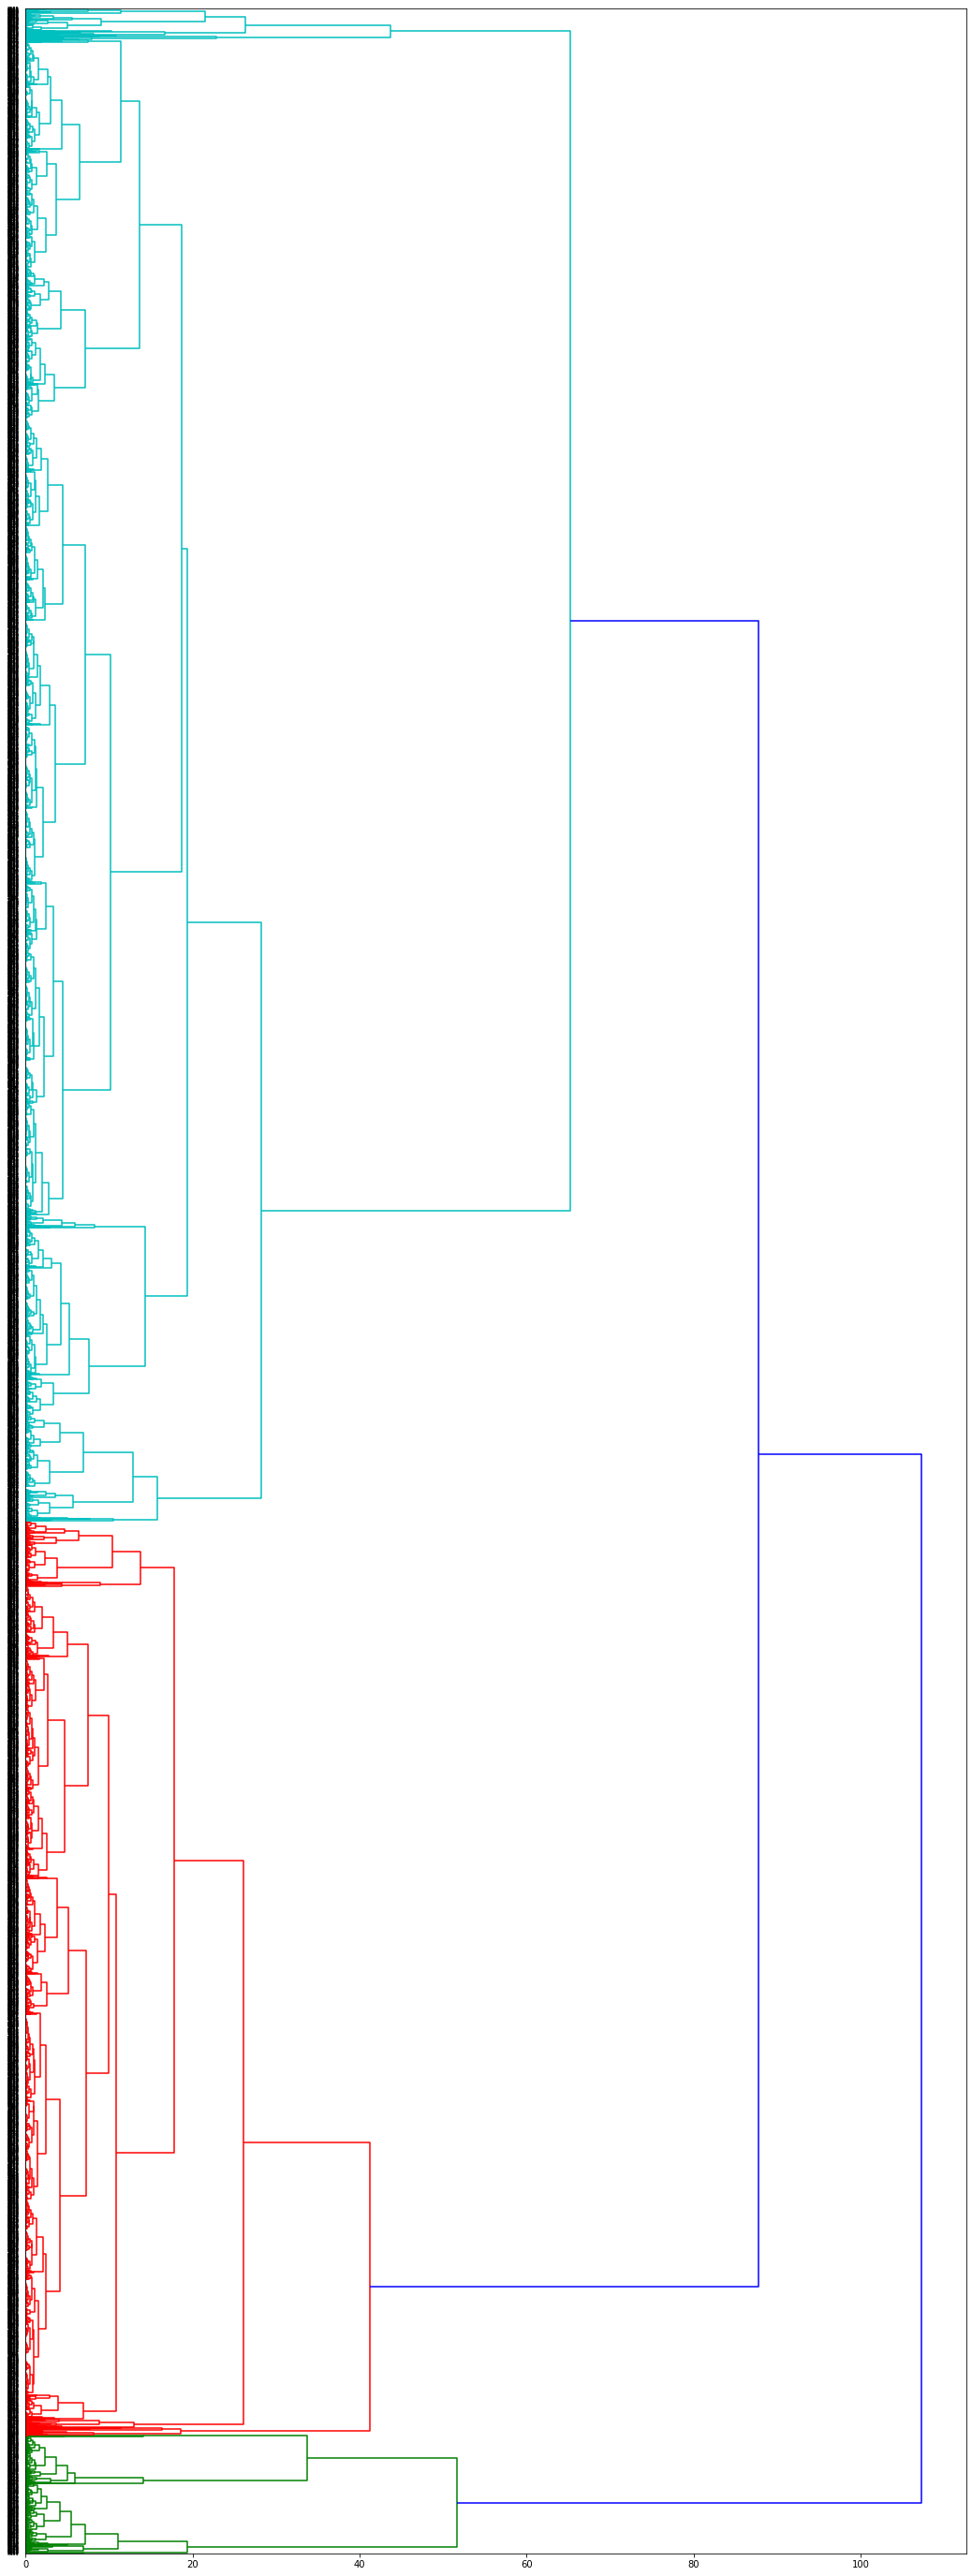

In [108]:
import pylab
import scipy.cluster.hierarchy
fig = pylab.figure(figsize=(18,50))

dendro = hierarchy.dendrogram(Z, leaf_rotation=0, orientation = 'right')
plt.savefig('dendogram.png', format='png', dpi = 300, orientation = 'landscape', transparent=False, bbox_inches='tight')

In [84]:
cdf['cluster_'] = agglom.labels_
cdf.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,DURATION,HOURLY_WAGE,AGENT_PRESENT,CASE_STATUS,cluster_
759346,6,47.4,1,0,0
356932,6,20.9,1,0,0
620091,4,35.7,0,0,2
663836,7,30.6,1,0,0
257533,6,33.9,0,0,2


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

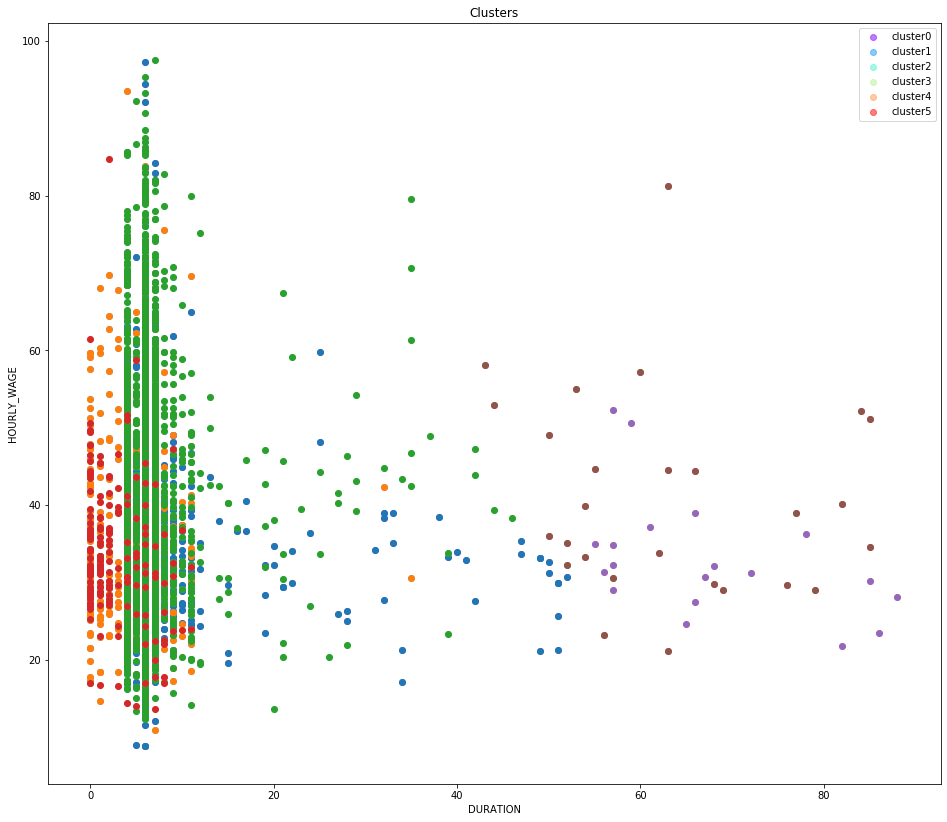

In [109]:
import matplotlib.cm as cm
n_clusters = max(agglom.labels_)+1
colors = cm.rainbow(np.linspace(0, 1, n_clusters))
cluster_labels = list(range(0, n_clusters))

# Create a figure of size 6 inches by 4 inches.
plt.figure(figsize=(16,14))

for color, label in zip(colors, cluster_labels):
    subset = cdf[cdf.cluster_ == label]
    #for i in subset.index:
            #plt.text(subset.DURATION[i], subset.HOURLY_WAGE[i],'Agent, Case status='+str(subset['AGENT_PRESENT'][i])+ ' , '+str(subset['CASE_STATUS'][i]), rotation=25) 
    plt.scatter(subset.DURATION, subset.HOURLY_WAGE, c=color, label='cluster'+str(label),alpha=0.5)
    plt.scatter(subset.DURATION, subset.HOURLY_WAGE)
plt.legend()
plt.title('Clusters')
plt.xlabel('DURATION')
plt.ylabel('HOURLY_WAGE')
plt.savefig('1-Hierierchial-clustering.png', dpi = 300, orientation = 'landscape', transparent=False, bbox_inches='tight')

As you can see, we are seeing the distribution of each cluster using the scatter plot, but it is not very clear where is the centroid of each cluster. Moreover, there are 2 types of CASE_STATUS in our dataset, "ACCEPTED" (value of 1 in the CASE_STATUS column) and "REJECTED" (value of 0 in the CASE_STATUS column). So, we use them to distinguish the classes, and summarize the cluster. First we count the number of cases in each group:

In [225]:
cdf.groupby(['cluster_','CASE_STATUS','AGENT_PRESENT'])['cluster_'].count()

cluster_  CASE_STATUS  AGENT_PRESENT
0         0            1                3443
1         1            0                 263
2         0            0                5690
3         1            1                 177
4         0            1                  19
5         0            0                  27
Name: cluster_, dtype: int64

Now we can look at the characteristics of each cluster:

In [111]:
agg = cdf.groupby(['cluster_','CASE_STATUS', 'AGENT_PRESENT'])['DURATION', 'HOURLY_WAGE'].mean()
agg

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,,,DURATION,HOURLY_WAGE
cluster_,CASE_STATUS,AGENT_PRESENT,,
0,0,1,6.266047,35.053180
1,1,0,3.444867,37.717110
2,0,0,6.081371,38.931810
3,1,1,2.632768,33.712429
4,0,1,67.473684,32.994737
5,0,0,63.037037,40.977778


From the data above we can see 2 main clusters for Case status 0, viz cluster 4 and cluster 5 with means 67.47 and 63.03.
For case status 1 the cluster 1 and cluster 3 seem to have majority of data points. Hourly wage seems to be comparitively uniformly distributed among clusters. For Agent Present 0, the cluster 5 seems to have majority data points for 'Duration" and Agent present 1, the cluster 4. Hourly wage again seems to be uniformly distributed among clusters.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

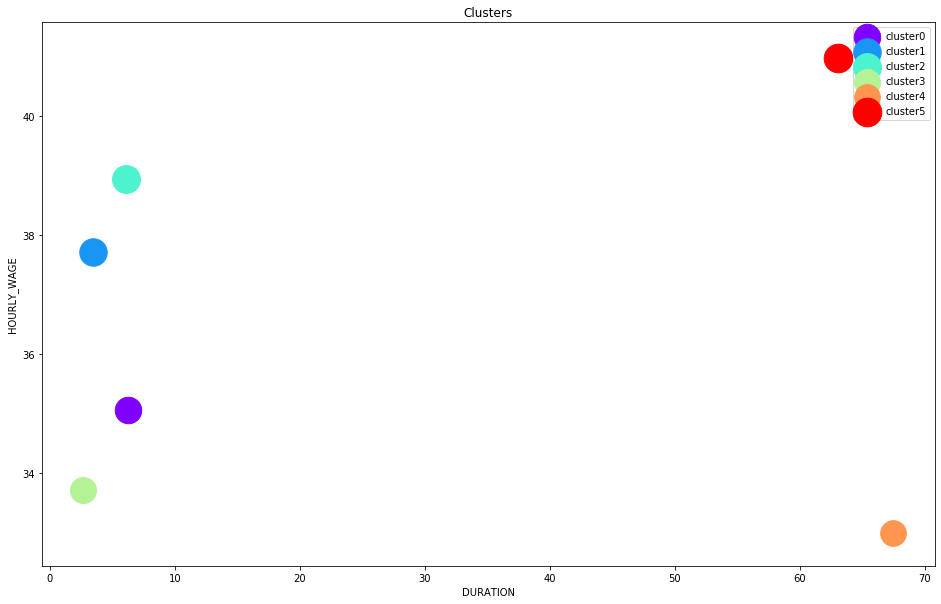

In [112]:
plt.figure(figsize=(16,10))
for color, label in zip(colors, cluster_labels):
    subset = agg.loc[(label,),]
    #for i in subset.index:
        #plt.text(subset.loc[i][0]+5, subset.loc[i][1], 'CASE_STATUS, AGENT_PRESENT='+str(i))
    plt.scatter(subset.DURATION, subset.HOURLY_WAGE, s=subset.HOURLY_WAGE*20, c=color, label='cluster'+str(label))
    
plt.legend()
plt.title('Clusters')
plt.xlabel('DURATION')
plt.ylabel('HOURLY_WAGE')
plt.savefig('2-hierierchial-clustering-2d.png', dpi = 300, orientation = 'landscape', transparent=False, bbox_inches='tight')

In [ ]:
Z = agg.linkage(dist_matrix, 'complete')